### Distributed Online Riemannian Optimization on Hadamard Manifolds

This Jupyter notebook implements decentralized projected Riemannian gradient descent (DPRGD) in several nonstationary decentralized Riemannian optimization problems. Our experiments include two types of Hadamard manifolds, hyperbolic spaces and the space of symmetric positive definite matrices. 

### Hyperbolic Spaces $\mathbb{H}^2$

In [2]:
import numpy as np

import matplotlib.pyplot as plt 

import hyperboloid

In the following experiment, we consider a network of $n=40$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

In [2]:
n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

#### 1 - Static setting

We generate $z_i$ from the Riemannian Gaussian distribution with base $\alpha=(1,0,0)$ in the hyperboloid model and $\sigma=5$. Then we draw $\{z_{ik}\}_{k=1}^K$ from the Riemannian Gaussian distribution with base $z_{i}$ and $\sigma=1$.

In [3]:
base = np.array([1, 0, 0])

base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

data = np.zeros((n, K, dim + 1))

for i in range(n):

    data[i] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)

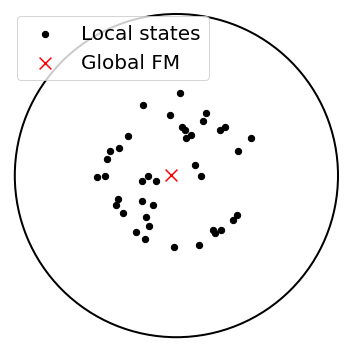

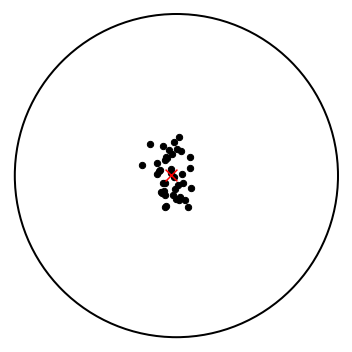

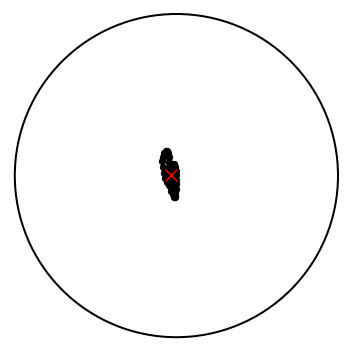

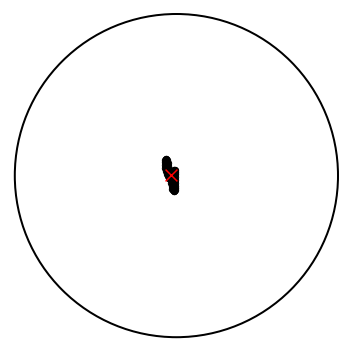

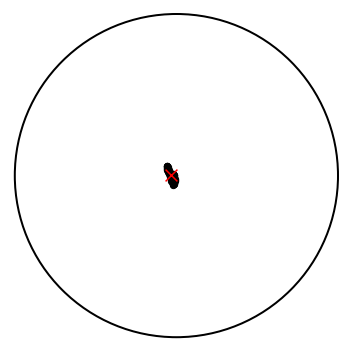

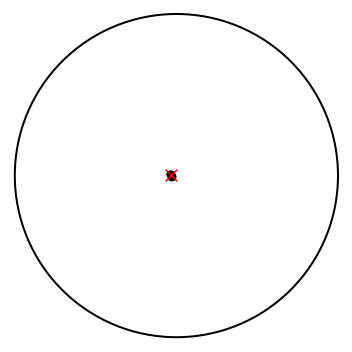

In [9]:
full_data = data.reshape(n * K, dim + 1)

global_mean = hyperboloid.frechet_mean(full_data) # global minimizer

state = np.zeros((n, dim + 1))

for i in range(n):

    state[i] = hyperboloid.frechet_mean(data[i]) # initial state using local frechet means

hyperboloid.visualize(state)

global_mean_poincare = hyperboloid.hyperboloid_to_poincare_ball(global_mean)

plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

plt.legend(loc = 'upper left', fontsize = 20)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_t_0.pdf')

plt.show()

T = 100

stepsize = 0.001

for t in range(T):

    state_new = np.zeros((n, dim + 1))

    for i in range(n):

        start = (i - 2) % n

        end = (i + 2) % n

        if start < end:

            neighbors_index = list(range(start, end + 1))

        else:

            neighbors_index = list(range(start, n)) + list(range(end + 1))

        state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

    for i in range(n):

        minus_gradient = np.mean(hyperboloid.log(state_new[i], data[i]), axis = 0)

        state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

    if t == 0 or t == 4 or t == 9 or t == 19 or t == 99:

        hyperboloid.visualize(state)

        plt.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')

        #plt.legend(loc = 'upper left', fontsize = 20)

        plt.tight_layout()

        plt.savefig('figure/hyperbolic_mean_t_' + str(t+1) + '.pdf')


#### 2 - Abrupt changing

We consider $T=400$ and let $\{f_{i,t}\}$ change every $T_0$ epochs, where $T_0\in\{25,40,80\}$ are examined. 
- When $t/T_0$ is an odd integer, we draw $\{z_i^t\}$ from the Riemannian Gaussian distribution with $\alpha=(3,2,2)$ and $\sigma=5$. Then we generate $\{z_{ik}^t\}$ from the Riemannian Gaussian distribution with $\alpha=z_i^t$ and $\sigma=1$. These $\{z_{ik}^t\}$ remain the same until $t/T_0$ reaches next integer. 
- When $t/T_0$ is an even integer, we draw $\{z_i^t\}$ from the Riemannian Gaussian distribution with $\alpha=(1,0,0)$ and $\sigma=5$. Then we generate $\{z_{ik}^t\}$ from the Riemannian Gaussian distribution with $\alpha=z_i^t$ and $\sigma=1$. These $\{z_{ik}^t\}$ remain unchanged until $t/T_0$ reaches next integer.

In [33]:
# 6 mins

n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

T = 400

T0_candidate = np.array([25, 40, 80])

stepsize_candidate = np.array([0.05, 0.05, 0.05])

dynamic_regret = np.zeros((len(T0_candidate), T))

state = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    stepsize = stepsize_candidate[s]

    for t in range(T):
        
        # generate data every T0 steps
        
        if t % T0 == 0:

            if (t // T0) % 2 == 0:

                base = np.array([1, 0, 0])

            else:

                base = np.array([3, 2, 2])

            base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

            data = np.zeros((n, K, dim + 1))

            for i in range(n):

                data[i] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)

            full_data = data.reshape(n * K, dim + 1)

            global_mean = hyperboloid.frechet_mean(full_data) # global minimizer
        
            loss_global = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state[i] = hyperboloid.frechet_mean(data[i]) # initial state using local frechet means

        state_new = np.zeros((n, dim + 1))

        # consensus step

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_new[i], data[i]), axis = 0)

            state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

        loss_local = np.zeros(n)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state[i], full_data) ** 2)

        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global

normalized_dynamic_regret = dynamic_regret / np.arange(1, T + 1)[np.newaxis, :]

Visualize the dynamic regret

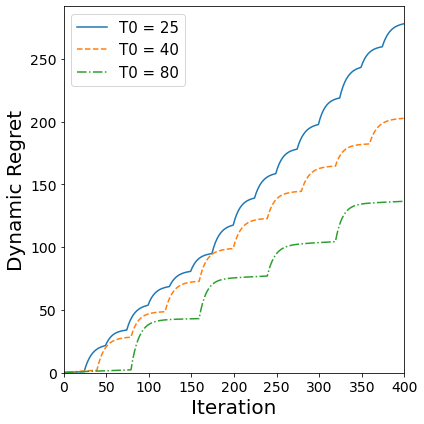

In [42]:
fig = plt.figure(figsize = (6, 6))

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]), linestyle = linestyle_candidate[s])

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Dynamic Regret', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_dynamic_regret_A.pdf')

plt.show()



#### 3 - General changing

We consider $T=400$ and allow $\{f_{i,t}\}$ to change abruptly and gradually. Specifically, we set a period length $T_0\in\{25,40,80\}$ and express each $t=sT+r$ with nonnegative integers $s$ and $r$. At time $t$, we set base as $\sinh(r/T_0)(1,0,0)+\sinh(r/T0)(0,1/\sqrt{2},1/\sqrt{2})$. Then we draw samples $\{z_i^t\}$ from the Riemannian Gaussian distribution with this base and $\sigma=5$. Next, we draw $\{z_{ik}\}$ from the Riemannian radial distribution with $\alpha=z_i^t$ and $\sigma=1$.

In [43]:
# 110 mins

n = 40 # number of agents

K = 100 # number of samples at each node

dim = 2 # dimension of the hyperbolic space

T = 400

T0_candidate = np.array([25, 40, 80])

stepsize_candidate = np.array([0.05, 0.05, 0.05])

dynamic_regret = np.zeros((len(T0_candidate), T))

state = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    for t in range(T):

        r = t % T0

        base = np.array([1, 0, 0]) * np.cosh(r / T0) + np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)]) * np.sinh(r / T0)

        base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 5)

        data = np.zeros((n, K, dim + 1))

        for i in range(n):

            data[i] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 1)

        full_data = data.reshape(n * K, dim + 1)

        global_mean = hyperboloid.frechet_mean(full_data) # global minimizer

        loss_global = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state[i] = hyperboloid.frechet_mean(data[i]) # initial state using local frechet means

        state_new = np.zeros((n, dim + 1))

        # consensus step

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(hyperboloid.log(state_new[i], data[i]), axis = 0)

            state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

        loss_local = np.zeros(n)

        for i in range(n):

            loss_local[i] = np.mean(hyperboloid.dist(state[i], full_data) ** 2)

        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global

normalized_dynamic_regret = dynamic_regret / np.arange(1, T + 1)[np.newaxis, :]

Visualize the dynamic regret

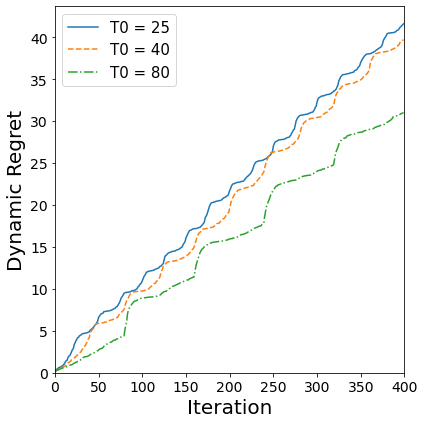

In [44]:
fig = plt.figure(figsize = (6, 6))

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    plt.plot(np.arange(T), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]), linestyle = linestyle_candidate[s])

plt.legend(fontsize = 15)

plt.xlabel('Iteration', fontsize = 20)

plt.ylabel('Dynamic Regret', fontsize = 20) 

plt.xlim(0, T)

plt.ylim(0, None)

plt.xticks(fontsize=14)

plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('figure/hyperbolic_mean_dynamic_regret_C.pdf')

plt.show()

### Symmetric Positive Definite Matrices

In [3]:
import numpy as np

import matplotlib.pyplot as plt 

import spd

In the following experiment, we consider a network of $n=8$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

In [82]:
n = 10 # number of agents

K = 30 # number of samples at each node

dim = 3 # consider 3 by 3 symmetric positive definite matrices

Consider $T=80$ and $T_0\in\{5,10,15\}$.

For the first 30 steps, we assume $\{f_{it}\}$ change abruptly. 

- When $t/T_0$ is an odd integer, we draw $Z_i^t\sim{\rm Exp}_I(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.5)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_i^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. 
- When $t/T_0$ is an even integer, we repeat the above procedure except that we replace $I$ by $2I$.

For the rest steps, we assume $\{f_{it}\}$ change abruptly and gradually. We let $t=sT_0+r$ with nonnegative integers $s$ and $r$. Then at time $t$, we draw $Z_i^t\sim{\rm Exp}_{(1+r/T_0)I}(V)$ where symmetric $V$ contains ${\cal U}(0,0.5)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_{i}^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. 

In [83]:
# 80 mins

T = 80

T0_candidate = np.array([5, 10, 15])

stepsize_candidate = np.array([0.05, 0.05, 0.05])

dynamic_regret = np.zeros((len(T0_candidate), T))

state = np.zeros((n, dim, dim))

for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]

    stepsize = stepsize_candidate[s]

    for t in range(T):

        if t < 30:

            if t % T0 == 0:

                if (t % T0) % 2 != 0:

                    base = np.eye(dim)

                else:

                    base = 3 * np.eye(dim)

                base_agent = spd.random(base, n_samples = n, radius = 0.2)

                data = np.zeros((n, K, dim, dim))

                for i in range(n):

                    data[i] = spd.random(base_agent[i], n_samples = K, radius = 0.1)

                full_data = data.reshape(n * K, dim, dim)

                global_mean = spd.frechet_mean(full_data) # global minimizer

                loss_global = np.mean(spd.dist(global_mean, full_data) ** 2)

        elif t >= 30:

            r = t % T0

            base = np.eye(dim) * (1 + r / T0 * 2)

            base_agent = spd.random(base, n_samples = n, radius = 0.2)

            data = np.zeros((n, K, dim, dim))

            for i in range(n):

                data[i] = spd.random(base_agent[i], n_samples = K, radius = 0.1)

            full_data = data.reshape(n * K, dim, dim)

            global_mean = spd.frechet_mean(full_data) # global minimizer

            loss_global = np.mean(spd.dist(global_mean, full_data) ** 2)

        # initialization only at time t = 0

        if t == 0:

            for i in range(n):

                state[i] = data[i][0]

        state_new = np.zeros((n, dim, dim))

        # consensus step

        for i in range(n):

            start = (i - 2) % n

            end = (i + 2) % n

            if start < end:

                neighbors_index = list(range(start, end + 1))

            else:

                neighbors_index = list(range(start, n)) + list(range(end + 1))

            state_new[i] = spd.frechet_mean(state[neighbors_index])

        # gradient step

        for i in range(n):

            minus_gradient = np.mean(spd.log(state_new[i], data[i]), axis = 0)

            state[i] = spd.exp(state_new[i], stepsize * minus_gradient)

        loss_local = np.zeros(n)

        for i in range(n):

            loss_local[i] = np.mean(spd.dist(state[i], full_data) ** 2)

        if t == 0:

            dynamic_regret[s, t] = np.mean(loss_local) - loss_global

        else:

            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global

normalized_dynamic_regret = dynamic_regret / np.arange(1, T + 1)[np.newaxis, :] 

Visualize the dynamic regret

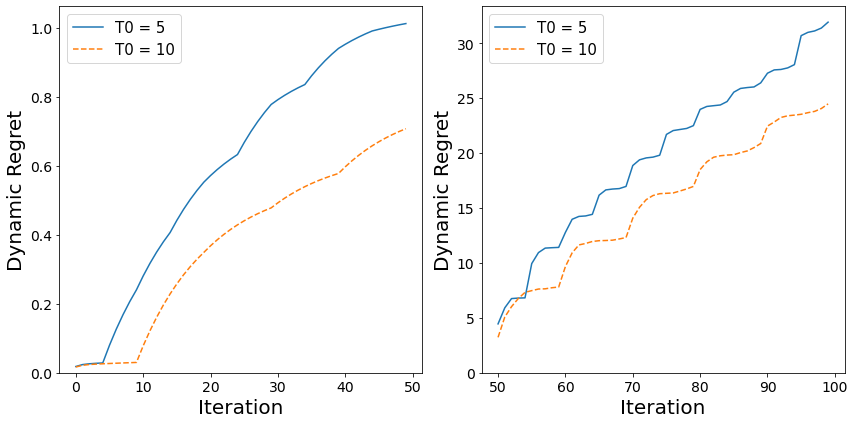

In [77]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

ax = axs[0]

linestyle_candidate = ['-', '--', '-.']

for s in range(len(T0_candidate)):

    ax.plot(np.arange(T)[:30], dynamic_regret[s][:30], label = 'T0 = ' + str(T0_candidate[s]), linestyle = linestyle_candidate[s])

ax.legend(fontsize = 15)

ax.set_xlabel('Iteration', fontsize = 20)

ax.set_ylabel('Dynamic Regret', fontsize = 20)  

ax.set_ylim(0, None) 

ax.tick_params(axis = 'both', labelsize = 14) 

ax = axs[1]

for s in range(len(T0_candidate)):

    ax.plot(np.arange(T)[30:], dynamic_regret[s][30:], label = 'T0 = ' + str(T0_candidate[s]), linestyle = linestyle_candidate[s])

ax.legend(fontsize = 15)

ax.set_xlabel('Iteration', fontsize = 20)

ax.set_ylabel('Dynamic Regret', fontsize = 20) 
 
ax.set_ylim(0, None) 

ax.tick_params(axis = 'both', labelsize = 14) 

plt.tight_layout()

plt.savefig('figure/SPD_dynamic_regret.pdf')

plt.show()